# (TODO) Notebook Title and description

# Setting up the running environment
These set of cells will prepare the environment to run the registration workflow

## Loading Modules
Work in the environment ISANDEX:
```workon isandex```

In [1]:
import os
import cv2 # Finally I can come back to OpenCV!!!
import itk
import sys
import math
import time
import ants
import json
import glob
import shutil
import roifile  # Opening the ImageJ-created ROIs (https://pypi.org/project/roifile/)
import itertools
import numpy as np
import pandas as pd
import dicom2nifti
import pydicom as pyd
from datetime import timedelta
import matplotlib.pyplot as plt
from directory_tree import display_tree  # Nice tool to display directory trees (https://pypi.org/project/directory-tree/)

print('All external modules loaded. Please check above for any error message!')
%matplotlib inline


All external modules loaded. Please check above for any error message!


## Auxiliar Functions

In [2]:
def list_folder_content(path, show_hidden=False):
    if show_hidden:
        ddfldrlst = os.listdir(path)
    else:
        ddfldrlst = list(filter(lambda item: not item.startswith('.'),os.listdir(path)))
    return ddfldrlst

def display_folder_list(file_list):
    print('\n'.join(f'[{idx}] - {file_idx}' for idx, file_idx in enumerate(file_list)))

def get_path_to_process(full_path):
    print('Folder content:')
    print(display_tree(full_path, header=True, string_rep=True, show_hidden=False, max_depth=2))
    folder_content = list_folder_content(full_path)
    # Ideally we'll have only one sub-folder inside the PreTreatment folder. If more than one, then we have to choose, but by default, we'll select the first one.
    idx_reg = 0
    if len(folder_content) > 1:
        display_folder_list(folder_content)
        idx_sel = input(f'Select the folder with the dataset_to_process to process (0-{len(folder_content)-1} or just press Enter to proceed with sub-folder {folder_content[idx_reg]}):')
        if idx_sel:
            idx_reg = int(idx_sel)
    path2data = os.path.join(full_path, folder_content[idx_reg])
    print(f'Will process {folder_content[idx_reg]}')
    return path2data

def check_time_points(path_to_check, nmax = 6, verbose=False):
    if path_to_check is not None:
        nr_of_folders = list_folder_content(path_to_check)
        print(f'Folder {path_to_check} seems Ok' if len(nr_of_folders)== nmax else f'Error! Check path {path_to_check} is the correct one')
        if verbose:
            print('Listing folder content:')
            display_tree(path_to_check, max_depth=1)
        return nr_of_folders if len(nr_of_folders) == nmax else None
    else:
        return None

def add_prefix_to_filename(full_path, prefix=None):
    # Assume the last part of the path is the filename (with extension)
    file_path, file_name_ext = os.path.split(full_path)
    if prefix:
        updated_filename = '_'.join([prefix, file_name_ext])
        return os.path.join(file_path, updated_filename)
    else:
        return prefix

def itk2ants(itkInput):
    antsOutput = ants.from_numpy(itk.GetArrayFromImage(itkInput).T,
                                 origin=tuple(itkInput.GetOrigin()),
                                 spacing=tuple(itkInput.GetSpacing()),
                                 direction=np.array(itkInput.GetDirection()))

    return antsOutput

def ants2itk(antsInput):
    itkOutput = itk.GetImageFromArray(antsInput.numpy().T)
    itkOutput.SetOrigin(antsInput.origin)
    itkOutput.SetSpacing(antsInput.spacing)
    itkOutput.SetDirection(antsInput.direction)

    return itkOutput

def getenv(colab=False):
    """
    Requires sys and os modules:
    import sys
    import os
    Possible values for sys.platform are (https://docs.python.org/3/library/sys.html & https://stackoverflow.com/questions/446209/possible-values-from-sys-platform)
    ┍━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┑
    │  System             │ Value               │
    ┝━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━┥
    │ Linux               │ linux or linux2 (*) │
    │ Windows             │ win32               │
    │ Windows/Cygwin      │ cygwin              │
    │ Windows/MSYS2       │ msys                │
    │ Mac OS X            │ darwin              │
    │ OS/2                │ os2                 │
    │ OS/2 EMX            │ os2emx              │
    │ RiscOS              │ riscos              │
    │ AtheOS              │ atheos              │
    │ FreeBSD 7           │ freebsd7            │
    │ FreeBSD 8           │ freebsd8            │
    │ FreeBSD N           │ freebsdN            │
    │ OpenBSD 6           │ openbsd6            │
    │ AIX                 │ aix (**)            │
    ┕━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━┙
    Update 03/04/2024: Added support when running inside Google Colab Environment, via the optional flag "colab"
    """
    if colab:
      # Requires mounting the Google Drive before
      HOMEPATH = '/content/drive/MyDrive'
    else:
      if sys.platform == 'win32':
          env_home = 'HOMEPATH'
      elif (sys.platform == 'darwin') | (sys.platform == 'linux'):
          env_home = 'HOME'
      HOMEPATH = os.getenv(env_home)

    return HOMEPATH

def check_path_exist(path, file=False):
    """
    Flag FILE indicates the path contains a file name (FLAG=TRUE) or the path only points to a folder (FLAG=FALSE (Default))
    """
    if file:
        is_path = os.path.isfile(path)
    else:
        is_path = os.path.isdir(path)

    print(f'{"OK:" if is_path else "ERROR:"} Path to {"file" if file else "folder"} {path} does{"" if is_path else " NOT"} exist')

    return is_path

def create_folder_structure(root_path, sub_dirs, create=True):
  """
  Create subdirectories insode HOMEPATH (using makedirs to avoid altering existing folders)
  ROOT_PATH must exist, otherwise it issues an error
  SUB_DIRS is a dictionary with the subfolder required inside HOMEPATH

  """
  subdirpaths = {}
  for folder_name, sub_dir in sub_dirs.items():
    path_to_subdir = os.path.join(root_path, sub_dir)
    if create:
        os.makedirs(path_to_subdir, exist_ok=True)
        subdirpaths[folder_name] = path_to_subdir


  return subdirpaths
print('All auxiliar functions defined. Ready to proceed')


All auxiliar functions defined. Ready to proceed


## Path to Data

In [3]:
# Create the Folder Structure (slightly different to the one created for testing registration methods, but still follows the same criteria)
HOMEPATH = getenv()
ROOTPATH = os.path.join(HOMEPATH, 'Data', 'fMRIBreastData')

SUBDIRFLDRS = {'STUDYFLDR':   'StudyData',
               'NIFTIFLDR':   'NiftiData',
               'ROIFLDR':     'ROIData',
               'SRCDCMFLDR':  'rawS3',
               'REGOUTFLDR':  'RegOutput',
               'CFGFLDR':     'configFiles',
               'OUTPUTFLDR':  'output',
               'LOGFLDR':     'logs'
              }
subdir_paths = create_folder_structure(ROOTPATH, SUBDIRFLDRS)

# DICOM Sources:
srcpath = subdir_paths['SRCDCMFLDR']
dstpath = subdir_paths['STUDYFLDR']
# Check the path exist and are correct:
# check_path_exist(srcpath)
# check_path_exist(dstpath)
fext = 'dcm'


Now that the folders have been created, (manually) place the dicom (raw) data into the ```rawS3``` folder (or whatever value is in ```subdir_paths['SRCDCMFLDR']```)

After done that, we'll sort them out automatically in the ```subdir_paths['STUDYFLDR']```

# Sort out DICOM folders
Sort out dicom files following this order:
* PatientID () --> Not used
* PatientName () --> Use this as it is also used by Radiologists, so to keep consistency
* StudyID () --> Not needed
* StudyDate () --> This defines the pre- and post-treatment (just the earliest is pre- and the latest is post-)
* SeriesNro () --> This is relevant to later eliminate any possible in-scanner post-processed data
* SeriesDescription ()


In [4]:
# Get the list of dicom files in the folder, use the extension defined by FEXT:
dcmlist = glob.glob(os.path.join(srcpath,f'*.{fext}'))
print(f'There are {len(dcmlist)} files to process in {srcpath}. Please wait...')

start_time = time.perf_counter()

nels = len(dcmlist)
nsteps = 10**math.floor(math.log10(0.01*nels)+1)

print(''.join(['*']*100))
for nimg, dcm in enumerate(dcmlist):
    if (nimg % nsteps)==0:
        print(f'\t{nels-nimg} files to process...')

    ds = pyd.dcmread(dcm,stop_before_pixels=True)
    [PatientID,
     PatientName,
     StudyDate,
     SeriesNro,
     TempPos] = [ds.PatientID, str(ds.PatientName), ds.StudyDate,
                 str(ds.SeriesNumber), str(ds.TemporalPositionIdentifier)]

    name_as_list = PatientName.split(' ')
    # remove multiple spaces:
    name_no_space = [i for i in name_as_list if i != '']
    # From the second element onward, use camel-case:
    name_camel_case = [i.title().replace('Treatmensst','Treatment') if idx>0 else i for idx, i in enumerate(name_no_space)]
    # Re-Join the name with a dash instead of (multiple) spaces:
    PatientName = '-'.join(name_camel_case)
    folderStruct = os.path.join(dstpath,
                                '-'.join([PatientName[:PatientName.find('-')],
                                          PatientID]),
                                '-'.join([PatientName.replace(' ','_'),
                                          StudyDate.replace(' ','_')]),
                                SeriesNro.replace(' ','_'),
                                TempPos.replace(' ','_'))
    os.makedirs(folderStruct, exist_ok=True)
    dstFile = os.path.join(folderStruct, os.path.split(dcm)[-1])
    if not os.path.isfile(dstFile):
        shutil.copy2(dcm, dstFile)
    else:
        print(f'File {dstFile}, already exists. Nothing done')
end_time = time.perf_counter()
elp_time = end_time - start_time
print(''.join(['*']*100))
print(f'All done (Elapsed time was {elp_time:.1f}[s]). Showing just the last folder processed:')
print(f'{folderStruct}')


There are 12600 files to process in /Users/joseulloa/Data/fMRIBreastData/rawS3. Please wait...
****************************************************************************************************
	12600 files to process...
File /Users/joseulloa/Data/fMRIBreastData/StudyData/CR-ANON68760/CR-Post-Treatment-20230120/301/3/bf498590-aac6-46fc-ad18-0de871ca1925.dcm, already exists. Nothing done
File /Users/joseulloa/Data/fMRIBreastData/StudyData/CR-ANON68760/CR-Post-Treatment-20230120/301/1/a35dd1a1-1c31-4a50-a961-907745c72232.dcm, already exists. Nothing done
File /Users/joseulloa/Data/fMRIBreastData/StudyData/NE-ANON89073/NE-Post-Treatment-Motion-Corrected-20221215/67799/3/ee3bbc5a-74a5-4e14-ba11-e4e511e25a0a.dcm, already exists. Nothing done
File /Users/joseulloa/Data/fMRIBreastData/StudyData/DC-ANON97378/DC-Post-Treatment-20230726/301/1/a05d357a-9682-40b2-a736-e7a39395a3c9.dcm, already exists. Nothing done
File /Users/joseulloa/Data/fMRIBreastData/StudyData/JB-ANON18218/JB-Pre-Treatment-

# Convert DICOM to NIFTI

In [5]:
dcmpath = subdir_paths['STUDYFLDR']
niftipath = subdir_paths['NIFTIFLDR']
# Check the path exist and are correct:
# check_path_exist(dcmpath)
# check_path_exist(niftipath)

# Displays the content of the DICOM folders that will be converted to NIFTI:
print(display_tree(dcmpath, header=True, string_rep=True, show_hidden=False, max_depth=4))


StudyData/
├── CR-ANON68760/
│   ├── CR-Post-Treatment-20230120/
│   │   └── 301/
│   │       ├── 1/
│   │       ├── 2/
│   │       ├── 3/
│   │       ├── 4/
│   │       ├── 5/
│   │       └── 6/
│   └── CR-Pre-Treatment-20221212/
│       └── 301/
│           ├── 1/
│           ├── 2/
│           ├── 3/
│           ├── 4/
│           ├── 5/
│           └── 6/
├── DC-ANON97378/
│   ├── DC-Post-Treatment-20230726/
│   │   └── 301/
│   │       ├── 1/
│   │       ├── 2/
│   │       ├── 3/
│   │       ├── 4/
│   │       ├── 5/
│   │       └── 6/
│   └── DC-Pre-Treatment-20230621/
│       └── 301/
│           ├── 1/
│           ├── 2/
│           ├── 3/
│           ├── 4/
│           ├── 5/
│           └── 6/
├── EilB-ANON98269/
│   ├── EilB-Post-Treatment-20230726/
│   │   └── 301/
│   │       ├── 1/
│   │       ├── 2/
│   │       ├── 3/
│   │       ├── 4/
│   │       ├── 5/
│   │       └── 6/
│   └── EilB-Pre-Treatment-20230621/
│       └── 501/
│           ├── 1/
│           ├── 2/
│     

In [6]:
# Expected sub-folder tree follows the pattern:
# PATIENT_INITIALS+"-"+PATIENTID -> PATIENT_NAME+"-"+DATE_OF_VISIT -> DCE_MRI_SEQUENCE
# Valid PATIENT_NAMES contains at most 3 dashes (i.e. to exclude "Motion Corrected" one, but keeping "RICE001")
#
start_time = time.perf_counter()
over_write = False # If the file exists, doesn't overwrite (i.e. doesn't convert it again)
concat_vol = False
PATIENTSID = list_folder_content(dcmpath)

print(''.join(['*']*100))
for patientID in PATIENTSID:
    path2patientID = os.path.join(dcmpath, patientID)
    patient_visits = list_folder_content(path2patientID)
    for visit_name in patient_visits:
        path2visit = os.path.join(path2patientID, visit_name)
        if visit_name.count('-') > 3:
            print(f'Folder Name is too long to match the criteria. Skipping {path2visit}')
            continue
        print(f'Processing {visit_name}. Please wait...')
        seq_nro = os.path.join(path2visit, list_folder_content(path2visit)[0])
        dce_time_points = list_folder_content(seq_nro)
        if concat_vol:
            tseries_volume = [None]*len(dce_time_points)
        for time_point_i in dce_time_points:
            path2time_point = os.path.join(seq_nro, time_point_i)
            print(f'Replicating sub-folder "{time_point_i}" in the output directory {niftipath}:')
            ipath = path2time_point
            opath = ipath.replace(dcmpath, niftipath)
            print(f'Creating folder {opath}...')
            try:
                os.makedirs(opath, exist_ok=True)
            except Exception as err:
                print(f'ERROR: Cannot create the folder {opath}')
                break
            if (not os.path.isdir(opath)) | over_write:
              print(f'Performing conversion from {ipath}, please wait...')
              dicom2nifti.convert_directory(ipath, opath)
              if concat_vol:
                  tseries_volume[int(time_point_i)-1] = itk.imread(glob.glob(os.path.join(opath,'*.nii.gz'))[0])
            else:
              print(f'File {opath}, already exists, nothing done. If you want to overwrite it, set the flag OVER_WRITE to TRUE')

        if concat_vol:
            print(f"Conversion done successfully, now will concatenate the timeseries into a single 4D volume saved at {os.path.join(path2visit.replace(dcmpath, niftipath),'.'.join([visit_name,'nii.gz']))}. Please wait a little bit more :) ...")
            # Initialise the 4d volume with the first time point (pre-contrast)
            t0_nii = tseries_volume[0]
            in_dim = t0_nii.GetImageDimension()
            pixel_type = itk.template(t0_nii)[1][0]
            out_dim = in_dim + 1

            input_image_type = itk.Image[pixel_type, in_dim]
            output_image_type = itk.Image[pixel_type, out_dim]

            layout = [1, 1, 1, len(dce_time_points)]
            vol_tiles = itk.TileImageFilter[input_image_type, output_image_type].New()
            vol_tiles.SetLayout(layout)
            for idx in range(len(dce_time_points)):
                vol_tiles.SetInput(idx, tseries_volume[idx])
            # Write 4D Volume:
            volume_writer = itk.ImageFileWriter[output_image_type].New()
            volume_writer.SetFileName(os.path.join(path2visit.replace(dcmpath, niftipath),'.'.join([visit_name,'nii.gz'])))
            volume_writer.SetInput(vol_tiles.GetOutput())
            volume_writer.Update()
            # And removing useless data:
            print(f'Removing {seq_nro} and its content...')
            shutil.rmtree(seq_nro.replace(dcmpath, niftipath))
        else:
            print('Conversion done successfully, moving to the next data folder.')
        print(''.join(['*']*100))

end_time = time.perf_counter()
elp_time = end_time - start_time

print(f'All done (Elapsed time was {elp_time:.1f}[s]), converted files have been saved at {dcmpath}. Bye!')


****************************************************************************************************
Processing DC-Pre-Treatment-20230621. Please wait...
Replicating sub-folder "6" in the output directory /Users/joseulloa/Data/fMRIBreastData/NiftiData:
Creating folder /Users/joseulloa/Data/fMRIBreastData/NiftiData/DC-ANON97378/DC-Pre-Treatment-20230621/301/6...
File /Users/joseulloa/Data/fMRIBreastData/NiftiData/DC-ANON97378/DC-Pre-Treatment-20230621/301/6, already exists, nothing done. If you want to overwrite it, set the flag OVER_WRITE to TRUE
Replicating sub-folder "1" in the output directory /Users/joseulloa/Data/fMRIBreastData/NiftiData:
Creating folder /Users/joseulloa/Data/fMRIBreastData/NiftiData/DC-ANON97378/DC-Pre-Treatment-20230621/301/1...
File /Users/joseulloa/Data/fMRIBreastData/NiftiData/DC-ANON97378/DC-Pre-Treatment-20230621/301/1, already exists, nothing done. If you want to overwrite it, set the flag OVER_WRITE to TRUE
Replicating sub-folder "4" in the output directo

# Register the Nifti datasets
Here, we separate the process in functions (similar to Inter-visit registration)
## Creates the dataset structure 
It holds the registration parameters and path to config files

In [21]:
savepath = subdir_paths['REGOUTFLDR']
studypath = subdir_paths['NIFTIFLDR']


configpath = subdir_paths['CFGFLDR']
logpath = subdir_paths['LOGFLDR']

# configpath = subdir_paths['CFGFLDR']
# Check the path exist and are correct:
# check_path_exist(dcmpath)
# check_path_exist(niftipath)


# default settings:
DEBUGMODE = True
BATCHMODE = False # TRUE: it runs the registration for all dataset within STUDYPATH; FALSE (DEFAULT): allows to pick a specific dataset to register
# Additional Flags to control execution of subsequent cells:
RUNREG = False # TRUE: it runs the registration cell; FALSE (DEFAULT): skips the registration to save time when just exploring the results

registration_algorithm = 'Elastix'
fixed_volume_pos = 2
register_fixed = True
config_files = ['Par0032_Elastix_Params_001_rigid.txt', 'Par0032_Elastix_Params_002_bsplines.txt']
txt_description = 'Default registration (Stage 1) of functional Breast DCE-MRI datasets'
platform = 'any'
bias_correction = 'n4itk'
histogram_matching = False


dataset_to_process = {'study_path': studypath,
                      'save_path': savepath,
                      'data_path': os.path.join(savepath, 'datasets'),
                      'parameters_folder': 'parameters',
                      'intended_platform': platform,
                      'run_platform': sys.platform,
                      'registration_details': {'algorithm': registration_algorithm,
                                               'configuration_files': config_files,
                                               'register_fixed': register_fixed},
                      'fixed_volume_position': fixed_volume_pos,
                      'preprocessing': {'bias_correction': bias_correction,
                                        'histogram_matching': histogram_matching},
                      'datasets': {}
                     }
# Create the top level folder(s) inside SAVEPATH:
os.makedirs(os.path.join(dataset_to_process['save_path'],dataset_to_process['parameters_folder']), exist_ok=True)

# Create description.json file from the descriptive variables defined in the previous cell:
description = {'Summary': txt_description,
               'Intended Platform': platform,
               'Run Platform': sys.platform,
               'Registration Details': {'algorithm': registration_algorithm,
                                        'configuration parameters': config_files,
                                        'reference volume': fixed_volume_pos,
                                        'register fixed': register_fixed},
               'Preprocessing': {'bias_correction': bias_correction,
                                 'histogram_matching': histogram_matching}
               }

# Save the description as a JSON file in the output directory:
with open(os.path.join(dataset_to_process['save_path'], 'description.json'), 'w') as fp:
    json.dump(description, fp)

print(f"Description file saved at {dataset_to_process['save_path']}")


Description file saved at /Users/joseulloa/Data/fMRIBreastData/RegOutput


## Selects the patient(s) to process

Select an index from the list or press "a" to process all of them

In [22]:
# List the patients in the root folder:
patients = list_folder_content(studypath)
print('Patient data folders:')
display_folder_list(patients)
if not BATCHMODE:
    # # Pick up an option:
    # patients_indices = range(len(patients))
    # patientIDX = None
    # while patientIDX not in patients_indices:
    patientIDX = input(f'Pick up a valid index to select a patient {tuple(range(len(patients)))} or type "a" to process all:')
    if patientIDX == 'a':
        print(f'Will process all patients in the test folder')
    else:
        patientIDX = int(patientIDX)
        patients = [patients[patientIDX]]
        if DEBUGMODE:
            print(f'Patient {patients[0]} selected contains the follow datasets:')
            print(display_tree(os.path.join(studypath, patients[0]), header=True, string_rep=True, show_hidden=False, max_depth=4))
else:
    print(f'Processing the whole data folder {studypath} as a batch process \n***Please be patient!!***')


Patient data folders:
[0] - DC-ANON97378
[1] - GL-ANON99397
[2] - JB-ANON18218
[3] - CR-ANON68760
[4] - EilB-ANON98269
[5] - RICE00-RICE001
[6] - NE-ANON89073
Will process all patients in the test folder


It is expected the patient folder contains only 2 sub-folders:
* PatientName-Pre-Treatment-\<visit-date\>
* PatientName-Post-Treatment-\<visit-date\>

and inside each of these sub-folders, there is the sequence number and the timepoints, where the corresponding Nifti file lives:
```
    PatientName-<Pre/Post>-Treatment-<visit-date>/
    ├── SeqNro/
        ├── 1/
            ├── <SeqNro>_<sequence-name>.nii.gz
        ├── 2/
            ├── <SeqNro>_<sequence-name>.nii.gz
        ├── 3/
            ├── <SeqNro>_<sequence-name>.nii.gz
        ├── 4/
            ├── <SeqNro>_<sequence-name>.nii.gz
        ├── 5/
            ├── <SeqNro>_<sequence-name>.nii.gz
        ├── 6/
            ├── <SeqNro>_<sequence-name>.nii.gz
```
Note that for each timepoint, there is no difference in the Nifti file name, it is only differentiated by the folder enclosing it

## Checks the dataset are ok

Review each sub-folder contains the right file and named correctly

In [23]:
# Organise the code to run for a single dataset and then, embed it into a loop for batch processing...
for patient in patients:
    # loop over patient datafolder (pre- and post-treatment)
    data_patient = os.path.join(studypath, patient)
    dataset_to_process['datasets'][patient]={'output_path': patient, # data_patient.replace(studypath, savepath),
                                 'visits': {}}
    patient_visits = list_folder_content(data_patient)
    checks = True
    if DEBUGMODE:
        print(f'Subfolders inside {data_patient}:\n\t{patient_visits}')
    print(''.join(['*']*50))
    for patient_visit in patient_visits:
        visit_name = patient_visit.split('-')
        seq_path = os.path.join(data_patient, patient_visit)
        seq_nro = list_folder_content(seq_path)[0]
        dataset_to_process['datasets'][patient]['visits'][''.join(visit_name[1:3])] = {'path': os.path.join(patient_visit, seq_nro),
                                                                           'path2fixed': ''}
        # Check the number of subfolders and depth are the expected ones:
        print(f'Checking {seq_path} contains only 1 folder...')
        check_nsequences_per_visit = check_time_points(seq_path, nmax=1, verbose=DEBUGMODE)
        if check_nsequences_per_visit is not None:
            print(f'Checking {seq_nro} contains the expected number of timepoints ...')
            check_timepoints_per_seq = check_time_points(os.path.join(seq_path, seq_nro), verbose=DEBUGMODE)
        else:
            checks = False

        if check_timepoints_per_seq is not None:
            dce_tpoints_path = list_folder_content(os.path.join(seq_path, seq_nro))
            dataset_to_process['datasets'][patient]['visits'][''.join(visit_name[1:3])]['path2moving'] = [None]*len(dce_tpoints_path)
            for time_point_i in dce_tpoints_path:
                print(f'Checking there is only one NIFTI file for each timepoint in {seq_nro}...')
                check_nfiles_per_timepoint = check_time_points(os.path.join(seq_path, seq_nro, time_point_i), nmax=1)
                get_nii_file = glob.glob(os.path.join(seq_path, seq_nro, time_point_i,'*.nii.gz'))
                if (check_nfiles_per_timepoint is not None) and (len(get_nii_file)==1):
                    print('Ready to load data...')
                    if int(time_point_i) == fixed_volume_pos:
                        dataset_to_process['datasets'][patient]['visits'][''.join(visit_name[1:3])]['path2fixed'] = get_nii_file[0]
                    dataset_to_process['datasets'][patient]['visits'][''.join(visit_name[1:3])]['path2moving'][int(time_point_i)-1] = get_nii_file[0]
                else:
                    checks = False
        else:
            checks = False

        if not checks:
            print(f'***ERROR***: There is something wrong with the data in {seq_path}, please check!!')
        print(''.join(['*']*100))
    if checks:
        print(f'All done loading NIFTI files from dataset {data_patient}')
    else:
        print(f'***ERROR***: There is something wrong with some (or all) data in {data_patient}, please check!!')
    print(''.join(['*']*100))

if DEBUGMODE:
    print(f'Details of the datasets to process:')
    print(json.dumps(dataset_to_process, indent=1))


Subfolders inside /Users/joseulloa/Data/fMRIBreastData/NiftiData/DC-ANON97378:
	['DC-Pre-Treatment-20230621', 'DC-Post-Treatment-20230726']
**************************************************
Checking /Users/joseulloa/Data/fMRIBreastData/NiftiData/DC-ANON97378/DC-Pre-Treatment-20230621 contains only 1 folder...
Folder /Users/joseulloa/Data/fMRIBreastData/NiftiData/DC-ANON97378/DC-Pre-Treatment-20230621 seems Ok
Listing folder content:
DC-Pre-Treatment-20230621/
└── 301/
Checking 301 contains the expected number of timepoints ...
Folder /Users/joseulloa/Data/fMRIBreastData/NiftiData/DC-ANON97378/DC-Pre-Treatment-20230621/301 seems Ok
Listing folder content:
301/
├── 1/
├── 2/
├── 3/
├── 4/
├── 5/
└── 6/
Checking there is only one NIFTI file for each timepoint in 301...
Folder /Users/joseulloa/Data/fMRIBreastData/NiftiData/DC-ANON97378/DC-Pre-Treatment-20230621/301/6 seems Ok
Ready to load data...
Checking there is only one NIFTI file for each timepoint in 301...
Folder /Users/joseulloa/D

## Registration Hyper-parameters


In [24]:
if dataset_to_process['registration_details']['algorithm'].lower() == 'ants':
    # ANTs
    # For details about possible values and description of parameters, see the help page: https://antspy.readthedocs.io/en/latest/registration.html
    # Default values (as listed in the hep page)
    dataset_to_process['par_set'] = {'type_of_transform': 'SyN',
                                     'initial_transform': None,
                                     'outprefix': '',
                                     'mask': None,
                                     'moving_mask': None,
                                     'mask_all_stages': False,
                                     'grad_step': 0.2,
                                     'flow_sigma': 3,
                                     'total_sigma': 0,
                                     'aff_metric': 'mattes',
                                     'aff_sampling': 32,
                                     'aff_random_sampling_rate': 0.2,
                                     'syn_metric': 'mattes',
                                     'syn_sampling': 32,
                                     'reg_iterations': (40, 20, 0),
                                     'aff_iterations': (2100, 1200, 1200, 10),
                                     'aff_shrink_factors': (6, 4, 2, 1),
                                     'aff_smoothing_sigmas': (3, 2, 1, 0),
                                     'write_composite_transform': False,
                                     'random_seed': None
                                    }

    # To ensure reproducibility of the results, set the random_seed to a constant value:
    dataset_to_process['par_set']['random_seed'] = 42 #(just to keep along with the pop-culture reference, e.g. https://medium.com/geekculture/the-story-behind-random-seed-42-in-machine-learning-b838c4ac290a
    # Save the parameters as a JSON file in the parameters folder:
    with open(os.path.join(dataset_to_process['save_path'], dataset_to_process['parameters_folder'], config_files[0]), 'w') as fp:
        json.dump(dataset_to_process['par_set'], fp)
elif dataset_to_process['registration_details']['algorithm'].lower() == 'elastix':
    # Elastix
    if DEBUGMODE:
        print(f'Define the parameters for the registration. Please wait...')
    dataset_to_process['par_set'] = itk.ParameterObject.New()
    for par_files in sorted(dataset_to_process['registration_details']['configuration_files']):
        dataset_to_process['par_set'].AddParameterFile(os.path.join(configpath, par_files))
        # Copy the parameters files to the output folder:
        shutil.copy2(os.path.join(configpath, par_files), os.path.join(dataset_to_process['save_path'],
                                                                       dataset_to_process['parameters_folder'],
                                                                       par_files))

    if DEBUGMODE:
        print('Parameters for ELASTIX:')
        print(dataset_to_process['par_set'])
else:
    print(f"Registration algorithm {dataset_to_process['registration_details']['algorithm']} not yet implemented. Please try again with a different option")


Define the parameters for the registration. Please wait...
Parameters for ELASTIX:
ParameterObject (0x316c55310)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 3653
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (AutomaticScalesEstimation "true")
  (AutomaticTransformInitialization "true")
  (BSplineInterpolationOrder 1)
  (CompressResultImage "true")
  (DefaultPixelValue 0)
  (ErodeMask "false")
  (FinalBSplineInterpolationOrder 1)
  (FixedImagePyramid "FixedRecursiveImagePyramid")
  (FixedInternalImagePixelType "short")
  (HowToCombineTransforms "Compose")
  (ITKTransformOutputFileNameExtension "h5")
  (ImagePyramidSchedule 4 4 4 2 2 2 1 1 1)
  (ImageSampler "Random")
  (Interpolator "BSplineInterpolator")
  (MaximumNumberOfIterations 250)
  (Metric "AdvancedMattesMutualInformation")
  (MovingImagePyramid "MovingRecursiveImagePyramid")
  (MovingInternalImagePixelType "short")
  (NewSamplesEveryIteration "true")
  (NumberOfHis

Loop over the patientes to run the registration --> ```list(dataset_to_process['datasets'].keys())```

The workflow inside the loop is as follows:
* Loop over the visits  --> ```list(dataset_to_process['datasets'][list(dataset_to_process['datasets'].keys())[i]]['visits'].keys())```
* Loads the Nifti file asigned to the fixed volume:
  * Initialises the 4D volume
  * Loops over the moving dataset --> ```dataset_to_process['datasets'][list(dataset_to_process['datasets'].keys())[i]]['visits'][list(dataset_to_process['datasets'][list(dataset_to_process['datasets'].keys())[j]]['visits'].keys())[z]]['path2moving']```
  * Loads the Nifti file
  * ```
        if moving_index == fixed_index:
            skips registration and assigns the output to aux
        else:
            runs registration
    ```
  * saves the output data
  * concatenate to 4D volume

  ## Finally, register all dataset

In [25]:
if RUNREG:
    print(f'Time at start: {time.ctime()}')
    init_time = time.perf_counter()
    for patient in dataset_to_process['datasets'].keys():
        start_registering_patient = time.perf_counter()
        for patient_visit in dataset_to_process['datasets'][patient]['visits']:
            start_registering_visit = time.perf_counter()
            patient_visit_outputpath = os.path.join(dataset_to_process['data_path'], patient, dataset_to_process['datasets'][patient]['visits'][patient_visit]['path'])
            print(patient_visit_outputpath)
            path2fixed = dataset_to_process['datasets'][patient]['visits'][patient_visit]['path2fixed']
            print(f'Fixed Volume: {path2fixed}')
            print(''.join(['-']*100))
            fixed_volume = itk.imread(path2fixed)
            fixed_voume_type = type(fixed_volume)
            if bias_correction is not None:
                # Apply the N4ITK correction to the fixed image
                print('Applying N4ITK correction to the fixed volume...')
                # fixed_volume_small = itk.shrink_image_filter(fixed_volume, shrink_factors=[2.0] * fixed_volume.GetImageDimension())
                # corrector = itk.N4BiasFieldCorrectionImageFilter.New(fixed_volume_small)
                # corrector.Update()
                fixed_volume_SS3 = itk.N4BiasFieldCorrectionImageFilter(fixed_volume)
                cast_filter_fixed_volume  = itk.CastImageFilter[type(fixed_volume_SS3), fixed_voume_type].New()
                cast_filter_fixed_volume.SetInput(fixed_volume_SS3)
                fixed_volume = cast_filter_fixed_volume.GetOutput()
                # fixed_volume.Update()
                # log_bias_field_fixed = fixed_volume.ReconstructBiasField(corrector.GetLogBiasFieldControlPointLattice())
                # itk.imwrite(log_bias_field, moving_set.replace(dataset_to_process['study_path'], dataset_to_process['data_path']))


            if dataset_to_process['registration_details']['algorithm'].lower() == 'ants':
                # Convert ITK image to ANTs:
                fixed_volume_ants = itk2ants(fixed_volume)
                # Test whether I need to separate the Bias Correction and use the one implemented in ANTsPy
                # https://antspy.readthedocs.io/en/latest/utils.html#ants.n4_bias_field_correction
                # ouput = ants.n4_bias_field_correction(input)

            # Get the list of moving datasets:
            moving_datasets = dataset_to_process['datasets'][patient]['visits'][patient_visit]['path2moving']

            # ITK concatenation output: Defines the 4D volume from this fixed image
            # To stack the volumes, use the function TileFilter, following the example at
            # https://examples.itk.org/src/filtering/imagegrid/create3dvolume/documentation
            # However, as I found out the hard way, the method SetInput works in order, even if it is within a loop, it works lexicographically (i.e. ordinal numbers)
            # so we'll recycle the list required for ANTs and after the registration, populates the tile in another (much quicker) loop
            input_dimension = fixed_volume.GetImageDimension()
            pixel_type = itk.template(fixed_volume)[1][0]
            output_dimension = input_dimension + 1
            input_image_type = itk.Image[pixel_type, input_dimension]
            output_image_type = itk.Image[pixel_type, output_dimension]
            layout = [1, 1, 1, len(moving_datasets)]
            registered_tiles = itk.TileImageFilter[input_image_type, output_image_type].New()
            registered_tiles.SetLayout(layout)


            for idx, moving_set in enumerate(moving_datasets):
                # Create the sub-folder in the output directories:
                os.makedirs(os.path.join(patient_visit_outputpath, str(idx+1)), exist_ok=True)
                # If the index is the Fixed Volume, just copy it to the output folder:
                if ((idx+1) == fixed_volume_pos) and (not register_fixed):
                    if (bias_correction):
                        # If bias field was applied, then we have to save the corrected image, instead of just copying the raw
                        itk.imwrite(fixed_volume, path2fixed.replace(dataset_to_process['study_path'], dataset_to_process['data_path']))
                    else:
                        print(f'No registration needed, {moving_set} is the fixed volume')
                        shutil.copy2(path2fixed, path2fixed.replace(dataset_to_process['study_path'], dataset_to_process['data_path']))
                    registered_tiles.SetInput(idx, fixed_volume)
                else:
                    # Any other case, just run the registration algorithm
                    print(f'Registering dataset {moving_set} to reference volume {path2fixed}. Please wait...')
                    start_registration_run = time.perf_counter()
                    moving_volume = itk.imread(moving_set)
                    moving_volume_type = type(moving_volume)
                    if bias_correction is not None:
                        # Apply the N4ITK correction to the moving image
                        print('Applying N4ITK correction to the moving volume...')
                        # moving_volume_small = itk.shrink_image_filter(moving_volume, shrink_factors=[2.0] * moving_volume.GetImageDimension())
                        # mov_corrector = itk.N4BiasFieldCorrectionImageFilter.New(moving_volume_small)
                        # mov_corrector.Update()
                        moving_volume_SS3 = itk.N4BiasFieldCorrectionImageFilter(moving_volume)
                        cast_filter_moving_volume  = itk.CastImageFilter[type(moving_volume_SS3), moving_volume_type].New()
                        cast_filter_moving_volume.SetInput(moving_volume_SS3)
                        # cast_filter_moving_volume.Update()
                        moving_volume = cast_filter_moving_volume.GetOutput()
                        # log_bias_field_moving = fixed_volume.ReconstructBiasField(mov_corrector.GetLogBiasFieldControlPointLattice())
                    if dataset_to_process['registration_details']['algorithm'].lower() == 'elastix':
                        if histogram_matching: # ANTsPy has this as default (see comment above)
                            # Apply histogram matching between fixed and moving
                            print('Applying histogram matching between fixed and moving images...')
                            moving_volume = itk.HistogramMatchingImageFilter(moving_volume, fixed_volume)
                        print('Running registration algorithm...')
                        warped_moving, result_transform_pars = itk.elastix_registration_method(fixed_volume ,
                                                                                                moving_volume,
                                                                                                parameter_object=dataset_to_process['par_set'],
                                                                                                log_to_console=False)
                    elif dataset_to_process['registration_details']['algorithm'].lower() == 'ants':
                        print('Running registration algorithm...')
                        moving_volume_ants = itk2ants(moving_volume)
                        if histogram_matching:
                            print('Applying histogram matching between fixed and moving images...')
                            moving_volume_ants = ants.histogram_match_image(moving_volume_ants, fixed_volume_ants)
                        registeredOutput = ants.registration(fixed=fixed_volume_ants , moving=moving_volume_ants, **dataset_to_process['par_set'])
                        warped_moving = ants2itk(registeredOutput['warpedmovout'])


                    end_registration_run = time.perf_counter()
                    elp_registration_single = end_registration_run - start_registration_run
                    print(f'Elapsed time to register single volume (incl. loading the data): {elp_registration_single:0.2f}[s] ({timedelta(seconds=elp_registration_single)})')
                    print(f'Adding registered volume to the 4D tile...')
                    registered_tiles.SetInput(idx, warped_moving)
                    print(f"Saving the output result in {moving_set.replace(dataset_to_process['study_path'], dataset_to_process['data_path'])}")
                    itk.imwrite(warped_moving, moving_set.replace(dataset_to_process['study_path'], dataset_to_process['data_path']))
                    print(f'Finished registering timepoint {idx+1}')
                print(''.join(['=']*100))
            end_registering_visit = time.perf_counter()
            elp_registration_visit = end_registering_visit - start_registering_visit
            print(f'Elapsed time to register all timepoints in a visit (incl. loading the data): {elp_registration_visit:0.2f}[s] ({timedelta(seconds=elp_registration_visit)})')

            if BATCHMODE:
                # When running in BatchMode adds a small pause to avoid the "IOStream.flush timed out" error
                print('Just breathing a little...')
                time.sleep(5)
                print('Ready to continue!')

            # Saving the 4D time series :
            start_saving_4Dvol = time.perf_counter()
            reg_writer = itk.ImageFileWriter[output_image_type].New()
            reg_writer.SetFileName(os.path.join(os.path.split(patient_visit_outputpath)[0],
                                                '.'.join([os.path.split(dataset_to_process['datasets'][patient]['visits'][patient_visit]['path'])[0],
                                                            'nii.gz'])))
            reg_writer.SetInput(registered_tiles.GetOutput())
            reg_writer.Update()

            end_saving_4Dvol = time.perf_counter()
            elp_saving_4Dvol = end_saving_4Dvol - start_saving_4Dvol
            print(f'Elapsed time to save the 4D volume: {elp_saving_4Dvol:0.2f}[s] ({timedelta(seconds=elp_saving_4Dvol)})')

            print(''.join(['*']*100))
    end_registering_patient = time.perf_counter()
    elp_registration_patient = end_registering_patient - start_registering_patient
    print(f'Elapsed time to register a whole patient dataset: {elp_registration_patient:0.2f}[s] ({timedelta(seconds=elp_registration_patient)})')
    print(''.join(['§']*100))

    final_time = time.perf_counter()
    elp_whole_loop = final_time - init_time
    print(f'Elapsed time to register the complete set of patientes in data folder {studypath}: {elp_whole_loop:0.2f}[s] ({timedelta(seconds=elp_whole_loop)})')
    print(f'Time at the end: {time.ctime()}')
else:
    print(f'Flag RUNREG={RUNREG}, so nothing done')


Flag RUNREG=False, so nothing done


# Applies the ROI and extract signal intensities from the registered dataset

In [26]:
# Loads the ROI dictionary
roi_dictionary = json.loads(open(os.path.join(subdir_paths['CFGFLDR'],'ROI_Dictionary.json')).read())
path_to_landmarks = os.path.join(subdir_paths['ROIFLDR'], 'datasets')
path_to_volumes = os.path.join(subdir_paths['REGOUTFLDR'], 'datasets')

nrows = 2
ncols = 2
rows_width = 12.0
cols_heigth = 10.0

kernel = np.ones((1)*3,np.uint8)
marker = itertools.cycle(['x','+','.','o','^','v'])

landmark_sel = 'tt'
# landmark_sel = ''


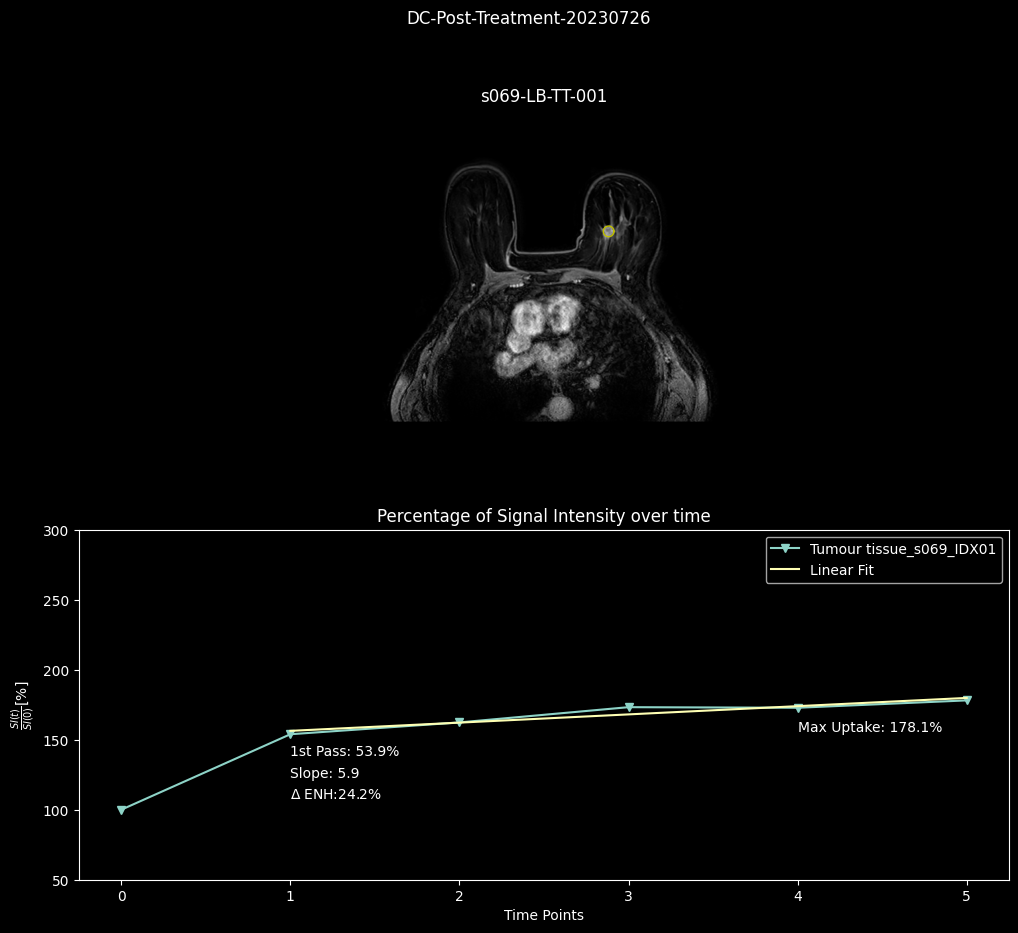

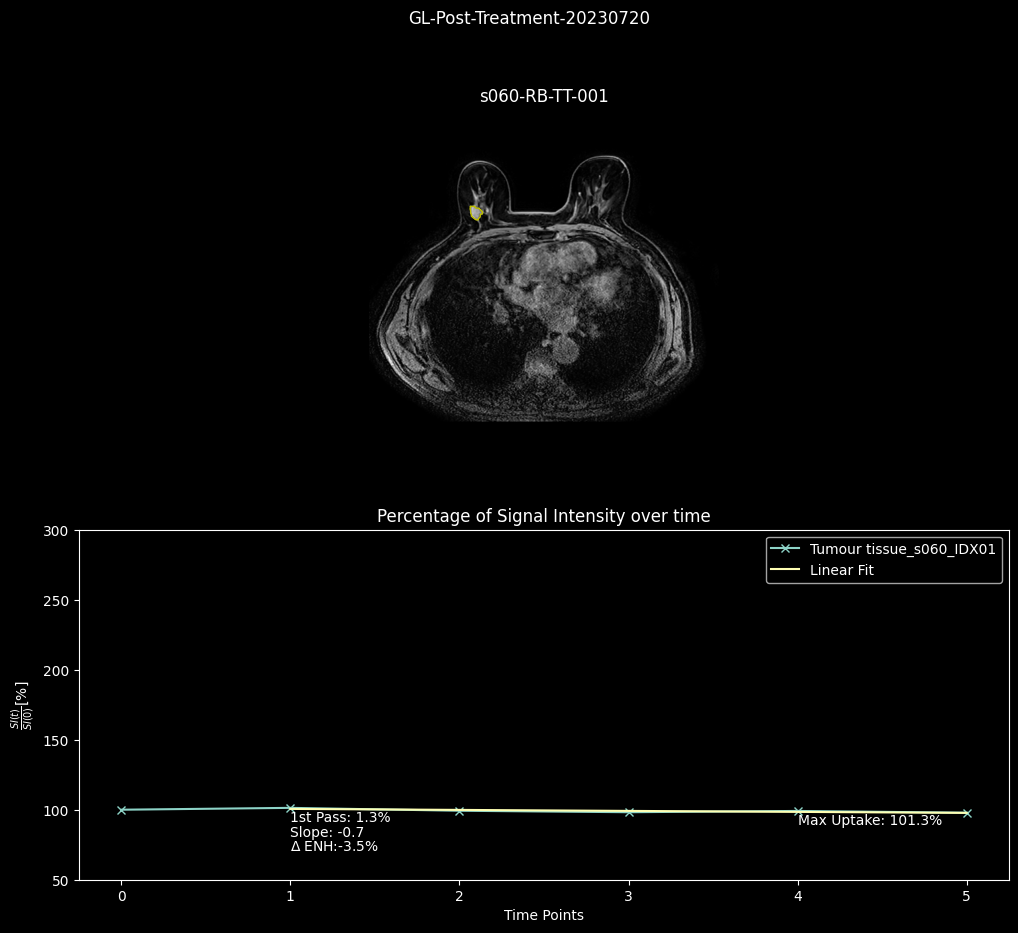

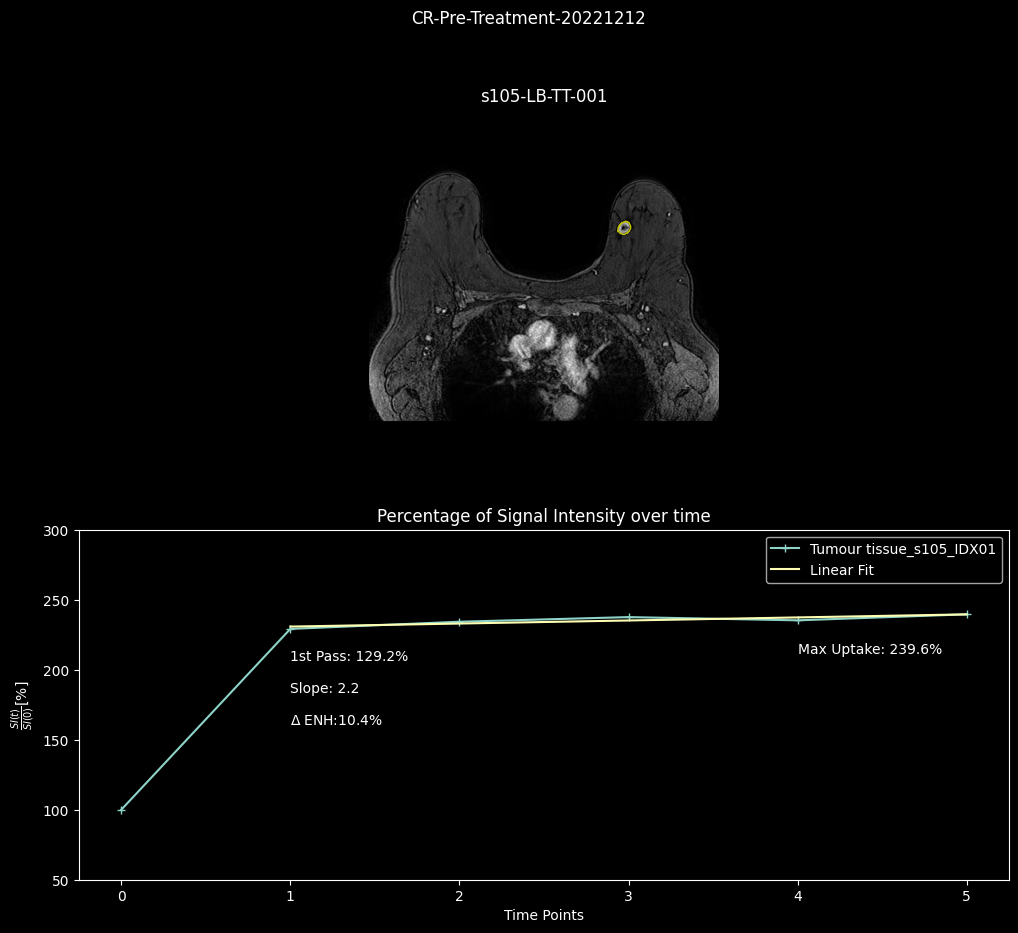

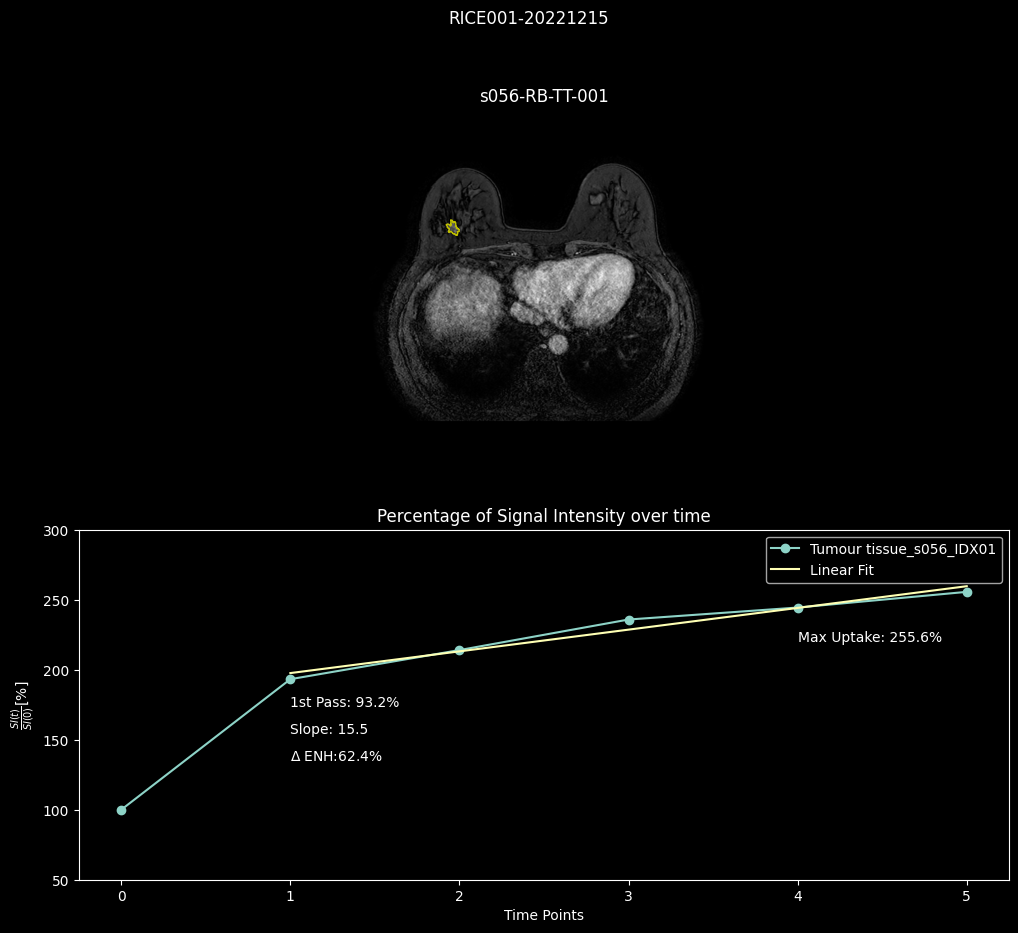

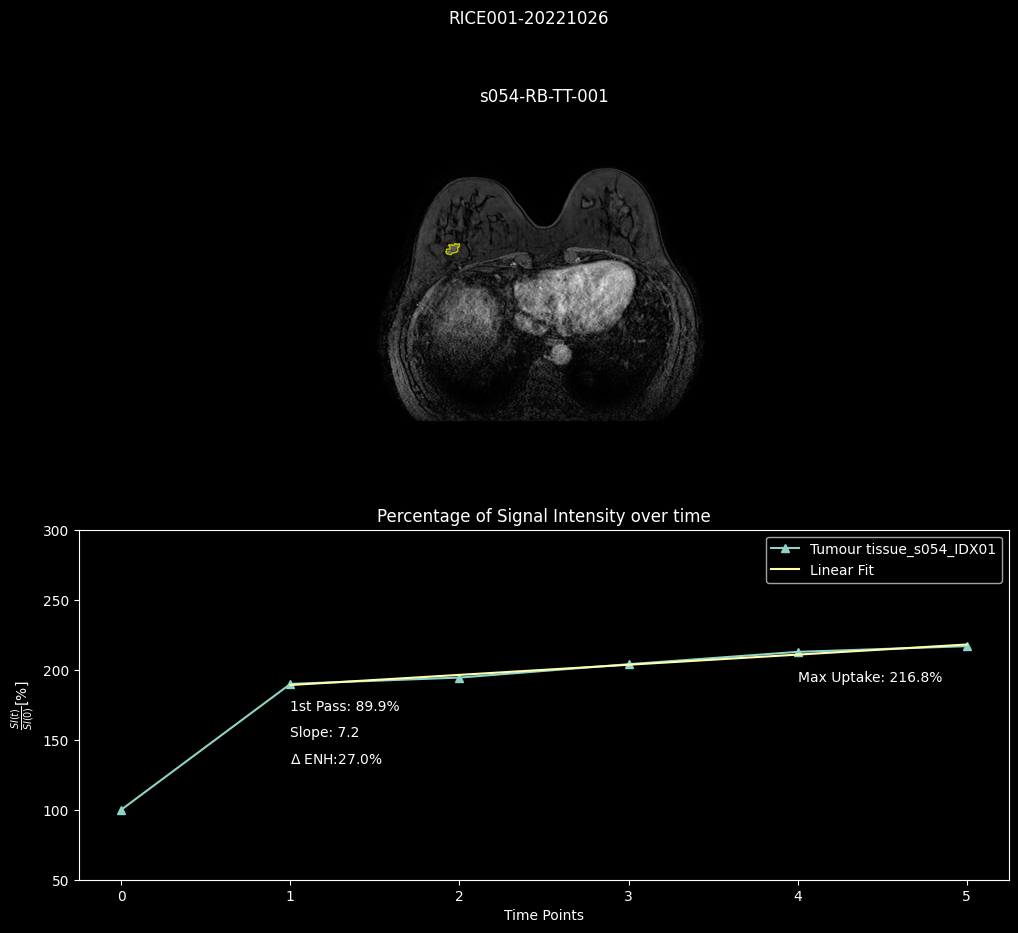

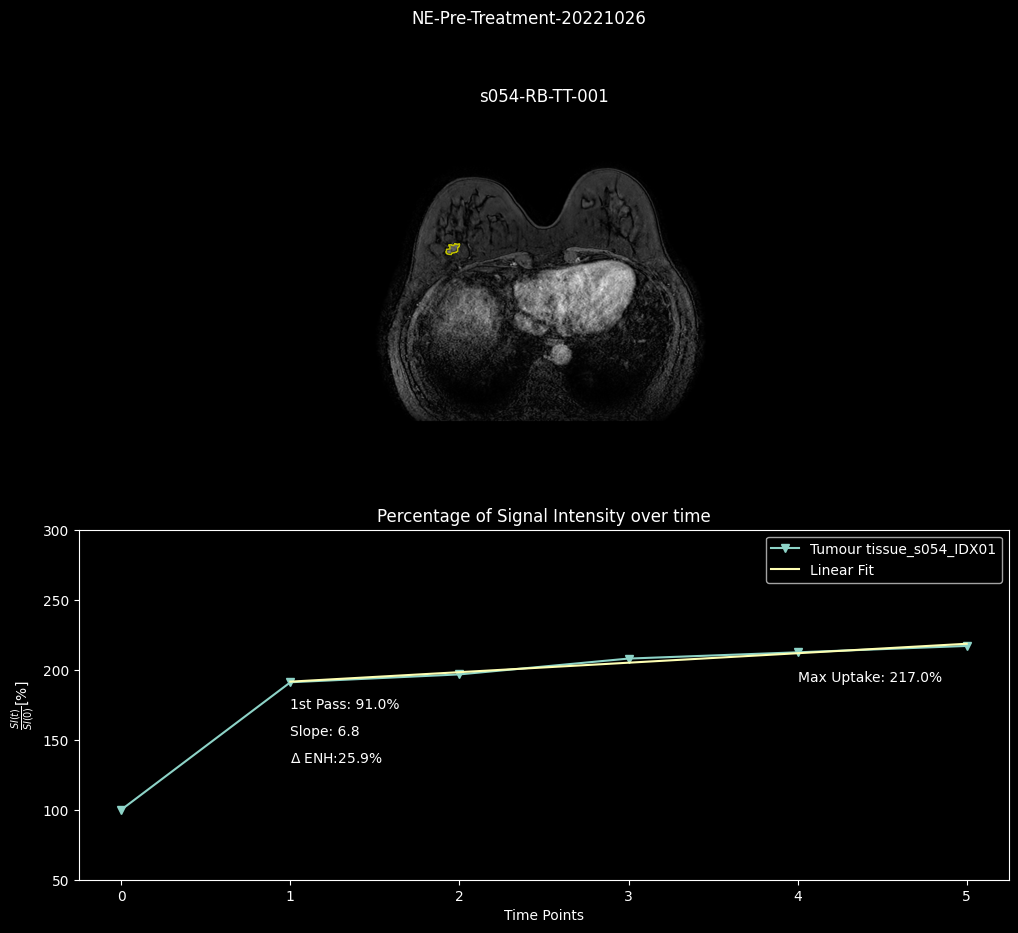

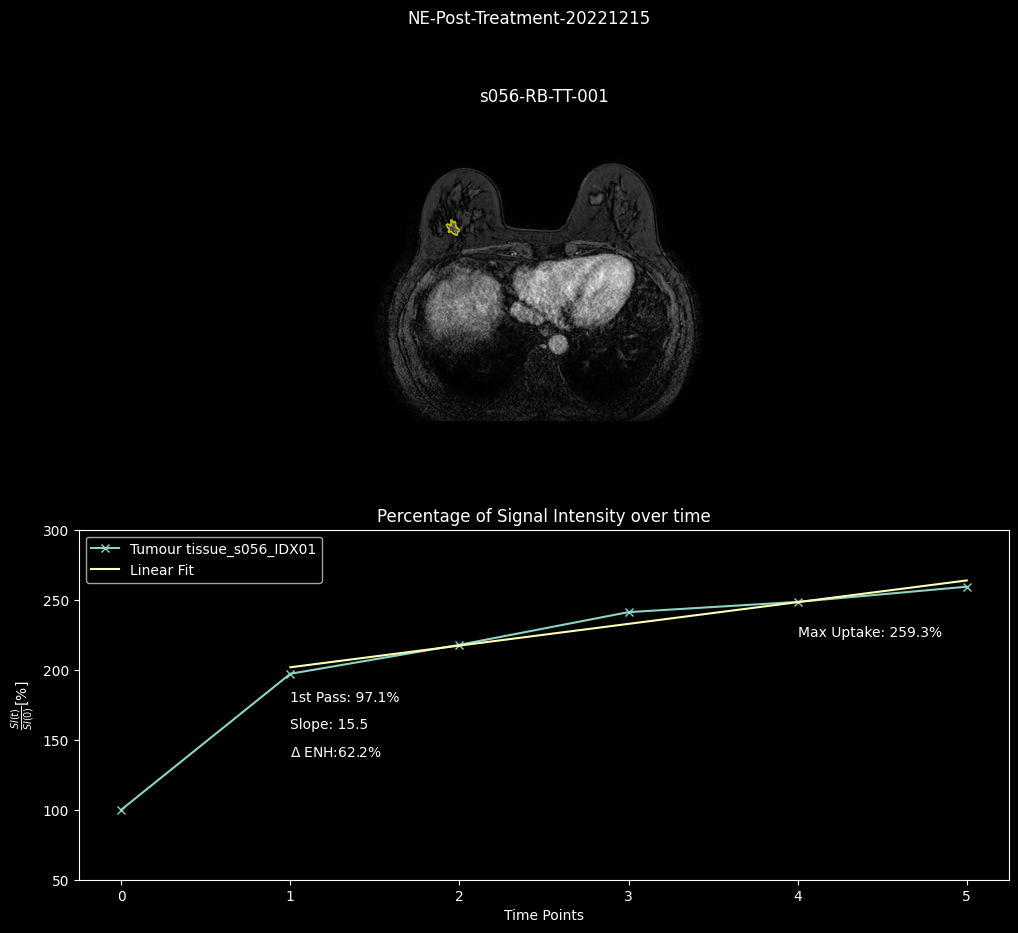

Patient  Patient_visit       Landmark SliceNro LandmarkIDX  \
0  DC-ANON97378   PreTreatment  Tumour tissue     s055         001   
1  DC-ANON97378  PostTreatment  Tumour tissue     s069         001   
2  GL-ANON99397  PostTreatment  Tumour tissue     s060         001   
3  CR-ANON68760   PreTreatment  Tumour tissue     s105         001   
4  CR-ANON68760  PostTreatment  Tumour tissue     s115         001   

                                         time_course  
0  [100.0, 173.84186, 180.35196, 183.67793, 183.4...  
1  [100.0, 153.91452, 162.3657, 173.25008, 172.83...  
2  [100.0, 101.33169, 99.265434, 98.2185, 99.1233...  
3  [100.00001, 229.15259, 234.27934, 237.58687, 2...  
4  [100.0, 228.68872, 244.95686, 249.86992, 257.3...

In [45]:
hdr = ['Patient','Patient_visit','Landmark', 'SliceNro','LandmarkIDX','time_course']# + [f't{tp:03d}' for tp in range(6)]
df_row = []
for patient in dataset_to_process['datasets'].keys():
    start_registering_patient = time.perf_counter()
    for patient_visit in dataset_to_process['datasets'][patient]['visits']:
        path_to_roi = os.path.join(path_to_landmarks, patient, os.path.dirname(dataset_to_process['datasets'][patient]['visits'][patient_visit]['path']), 'landmarks', 'RoiSet-Frame002.zip')
        # Load the image volume and see how can I overlay the ROI:
        path_to_volume = os.path.join(path_to_volumes, patient, 
                                      os.path.dirname(dataset_to_process['datasets'][patient]['visits'][patient_visit]['path']), 
                                      '.'.join([os.path.split(dataset_to_process['datasets'][patient]['visits'][patient_visit]['path'])[0],
                                                'nii.gz']))
        if os.path.isfile(path_to_roi):
            roi_zip_file = roifile.ImagejRoi.fromfile(path_to_roi)
            volume_4d_file = itk.imread(path_to_volume)
            # Using Matplotlib to display the images (for now skip the 3D visualisation issue with itk.view)
            nrois = len(roi_zip_file)
            nt = volume_4d_file.shape[0]
            if landmark_sel == '':
                ncols = nrois
            else:
                ncols = 1
            si_landmark = {}

            fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(rows_width, cols_heigth), sharey='row')
            fig.suptitle(os.path.dirname(dataset_to_process['datasets'][patient]['visits'][patient_visit]['path']))
            tcourse_ax = fig.add_subplot(2,1,2)
            axr = ax.ravel()

            for idx_roi, roi in enumerate(roi_zip_file):
                coordinates = (roi.t_position - 1, roi.z_position - 1) # Indices start in 0, but in ImageJ, slice and time points start in 1
                [slice_nro, locID, landmrkID, landmarkIDX] = roi.name.split('-')
                location = roi_dictionary['locations'][locID.lower()].capitalize()
                landmark = roi_dictionary['landmarks'][landmrkID.lower()].capitalize()                    
                if landmark_sel == '':
                    img_ax = ax[0, idx_roi]# img_ax = ax[idx_roi, 0]
                else:
                    img_ax = axr[0]
                    
                if (landmrkID.lower() == landmark_sel) | (landmark_sel == ''):
                    time_courses = [patient, patient_visit, landmark, slice_nro, landmarkIDX]
                    slice_to_plot = volume_4d_file[coordinates[0],coordinates[1],::-1,:]
                else:
                    continue
                img_ax.imshow(slice_to_plot, cmap='gray')
                img_ax.set_title(roi.name)
                roi.plot(ax=img_ax, linewidth=1, color='y')
                # img_ax.axis([275, 450, 300, 70])
                img_ax.axis('off')
                # Create a mask from the set of coordinates:
                mask = np.zeros_like(slice_to_plot, dtype=np.uint8)
                pts = roi.coordinates().round().astype(np.int32)
                mask = cv2.fillPoly(mask, [pts], (1))
                mask = cv2.erode(mask, kernel, iterations=1)
                
                si = [np.mean(np.asarray(volume_4d_file[ti,coordinates[1],::-1,:] * mask), where=(mask>0)) for ti in range(volume_4d_file.shape[0])]
                pc_si = list(si/(si[0]/100))
                roi_label = f"{landmark}_{slice_nro}_IDX{int(landmarkIDX):02d}"
                si_landmark[roi_label] = pc_si
                if landmark_sel == '':
                    plt_ax = ax[1, idx_roi]
                else:
                    plt_ax = axr[1]
                plt_ax.remove()
                time_courses.append(pc_si)
                time_course_df = pd.DataFrame(si_landmark)
                df_row.append(time_courses)
                tcourse_ax.plot(pc_si, marker=next(marker), label=roi_label)
                if landmrkID.lower() == landmark_sel:
                    # get stats of the timecourse signal:
                    t0 = 1 
                    t_axis = range(t0, nt)
                    y_hat = pc_si[t0:]
                    first_pass_enh = pc_si[1]-pc_si[0]
                    max_uptk = np.max(pc_si)
                    delta_enh = pc_si[-1] - pc_si[t0]
                    p = np.polyfit(t_axis, y_hat, 1)
                    tcourse_ax.text(t_axis[-2], 0.90*pc_si[-2], f'Max Uptake: {max_uptk:0.1f}%')
                    tcourse_ax.text(t0, 0.70*pc_si[t0], r'$\Delta$ ENH:' + f'{delta_enh:0.1f}%')
                    tcourse_ax.text(t0, 0.80*pc_si[t0], f'Slope: {p[0]:0.1f}')
                    tcourse_ax.text(t0, 0.90*pc_si[t0], f'1st Pass: {first_pass_enh:0.1f}%')
                    tcourse_ax.plot(t_axis, np.polyval(p, t_axis), label='Linear Fit')
                    tcourse_ax.set_ylim([50, 300])
                    # tcourse_ax.grid(True)
            tcourse_ax.set_title(f'Percentage of Signal Intensity over time')
            tcourse_ax.set_xlabel(f'Time Points')
            tcourse_ax.set_ylabel(r'$\frac{SI(t)}{SI(0)}$[%]')
            tcourse_ax.legend()

            plt.savefig(os.path.join(subdir_paths['OUTPUTFLDR'], '.'.join([os.path.dirname(dataset_to_process['datasets'][patient]['visits'][patient_visit]['path']),
                                                                           'png'])))
            plt.show()
        
df = pd.DataFrame(columns=hdr, data=df_row)
df.head()
